# Part 1B: Sale Prediction via Auto Regression

### Crucial Functions

Here we setup $A$ and $b$ both to solve least squares for $w$ (i.e. weights) and for $a$ (i.e. missing sale entries)

In [1]:
def setup_phase_2(d_tau, b, A_index, A, w ,sales_data):
    N_row = len(b)
    nan_locations = np.nonzero(np.isnan(sales_data))
    b_new = []
    A_new = []
    for i in range(N_row):
        include = check_row(i,d_tau, b, A, A_index, sales_data, w)
        if include:
            b_new.append(include[0])
            A_new.append(include[1])
    return b_new, A_new


def setup_phase_1(d_tau, sales_data):
    N_item = sales_data.shape[0]
    N_window = d_tau * N_item
    row_len = d_tau * (N_item ** 2)

    b = sales_data[:,d_tau:].flatten(order='F')  # vectorize column by column
    col_len = len(b)

    A = np.zeros([col_len ,row_len])
    A_index = np.zeros([col_len ,row_len], dtype=(int, 2)) - 1
    for i in range(col_len):  # iterate for each row
        item, month = calculate_b_index(d_tau, N_item, i)

        r = np.arange(0, N_item)
        c = np.arange(month - d_tau, month)
        row_index, r, c = form_tuple_list(r, c)
        row = sales_data[r, c]

        start = item * N_window
        end = start + N_window
        A[i,start:end] = row
        A_index[i,start:end] = row_index

    return b, A_index, A

#### Helper function to setup $A$ and $b$ in order to solve for $w$

In [2]:
def check_row(i, d_tau, b, A, A_index, sales_data, w):
    N_item = sales_data.shape[0]
    nan_locations = np.nonzero(np.isnan(sales_data))
    nan_tuples = np.vstack([nan_locations[0], nan_locations[1]])
    nan_tuples = to_tuple(nan_tuples)
    N_nans = len(nan_tuples)

    bi = calculate_b_index(d_tau, N_item, i)
    to_check = np.vstack([bi, A_index[i,:]])
    c = 0
    qualified = False
    current_b = 0
    current_row = [0] * N_nans
    for elem in to_check:
        elem = tuple(elem)
        if elem != (-1,-1):
            if elem in nan_tuples:
                qualified = True
                index = nan_tuples.index(elem)
                if c == 0:
                    current_row[index] = -1
                else:
                    current_row[index] = w[c-1]
            else:
                if c > 0:
                    current_b += (-w[c-1]) * sales_data[elem]
                else:
                    current_b += b[i]
        c += 1
    if qualified:
        return current_b, current_row
    else:
        return False

### General Helper Functions

In [3]:
def to_tuple(v):
    rv = []
    for el in v.T:
        rv.append((el[0], el[1]))
    return rv


def calculate_b_index(d_tau, N_item, index):
    month = index / N_item + d_tau
    item = index % N_item
    return item, month


def form_tuple_list(a1, a2):
    rv1= []
    rv2= []
    rv3= []
    for e1 in a1:
        for e2 in a2:
            rv1.append((e1,e2))
            rv2.append(e1)
            rv3.append(e2)
    return rv1, rv2, rv3


def next_six_months(d_tau, w, sales_data):
    N_item = sales_data.shape[0]

    for i in range(6):
        future_sales = np.zeros([N_item, 1])
        for j in range(N_item):
            a = sales_data[:, -d_tau:]
            wj = w[j,:,:]
            future_sales[j] = np.sum(a * wj)
        sales_data = np.hstack([sales_data, future_sales])
    return sales_data[:,-6:]


def remove_nans(row_vector):
    months = np.nonzero(~np.isnan(row_vector))[0]
    sales = row_vector[months]
    return months, sales

### Main Functions

In [6]:
def auto_regression(d_tau, sales_data, test_data=None):
    sales_data_true = sales_data.copy()
    N_item = sales_data.shape[0]
    nan_locations = np.nonzero(np.isnan(sales_data))
    sales_data[nan_locations] = np.random.rand() + 300

    for i in range(30):
        # Phase 1: solve for weights
        b, A_index, A = setup_phase_1(d_tau, sales_data)
        w = np.linalg.lstsq(A, b)[0]

        if len(nan_locations[0]) == 0: break

        # # Phase 2: solve for nans
        b, A = setup_phase_2(d_tau, b, A_index, A, w, sales_data_true)
        k = np.linalg.lstsq(A, b)[0]
        sales_data[nan_locations] = k

    rv = np.reshape(w, [N_item, N_item, d_tau])
    return rv

def project_part1_2(d_tau, train, test=None):
    trc = train.copy()
    w = auto_regression(d_tau, trc)
    future_months = np.arange(trc.shape[1],trc.shape[1]+6)
    future_sales = next_six_months(d_tau, w, trc)
    errors = None
    if test is not None:
        errors = test - future_sales

    plt.figure(figsize=(16.0, 8.0))
    colors = ['r','k','g','b','m','y','c']
    for i in range(train.shape[0]):
        past_months, past_sales = remove_nans(train[i, :])
        plt.plot(past_months, past_sales, '--o', color=colors[i],lw=0.7, ms=6.0)
        # missing = np.nonzero(np.isnan(R_true[i,:]))
        # plt.plot(missing ,train[i, missing], 's', color=colors[i], ms=8)
        plt.plot(future_months, future_sales[i,:], '^', color=colors[i], ms=8)
    plt.show()

    return w, future_months, future_sales, errors

### Test 1: Dataset without NaN's

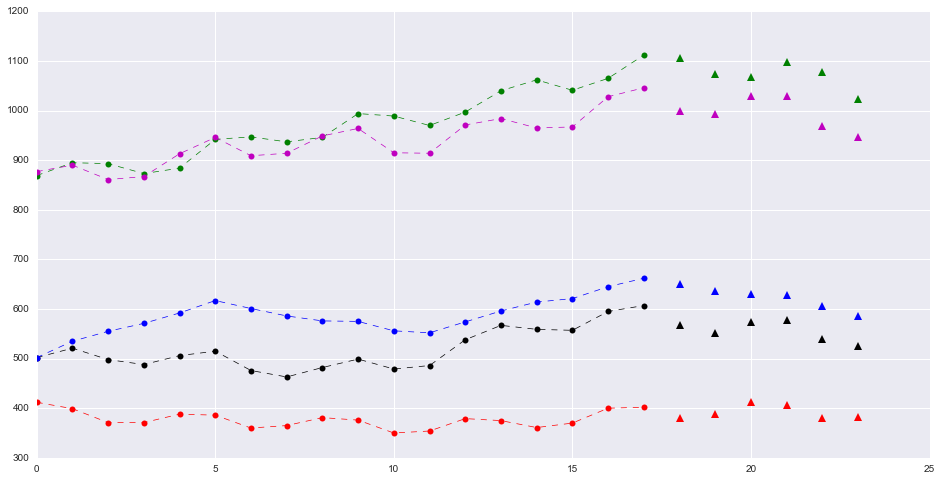

Errors : 
[[  5.5    8.7    7.16   4.83   4.08   3.41]
 [  6.57  16.95  23.08  34.4   50.8   70.2 ]
 [ 12.62  21.05  19.78  14.94  17.5   29.93]
 [  6.62  16.23  24.17  36.97  61.34  95.45]
 [ 14.24  25.5   29.17  32.58  46.99  66.57]]


In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(12345)
np.set_printoptions(precision=2,suppress=False)

R_true = np.genfromtxt('dataset11.csv', delimiter=',',dtype=float)
#train = R_true.copy()
#test = None
train = R_true[:,:18].copy()
test = R_true[:,18:].copy()
w, pred_month, pred_sales, errors = project_part1_2(4, train, test) # d_tau is 4

print 'Errors : \n', errors

### Test 2: Dataset with NaN's

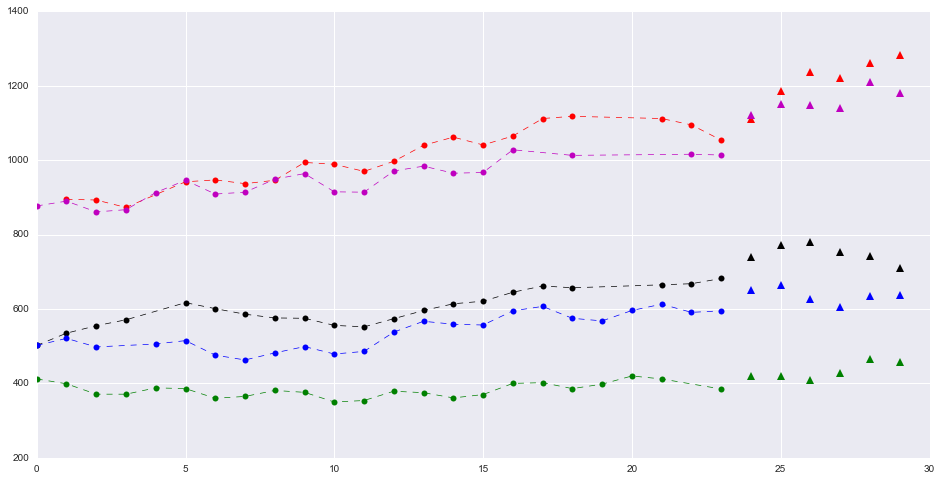

Errors : 
None


In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(12345)
np.set_printoptions(precision=2,suppress=False)

R_true = np.genfromtxt('dataset12.csv', delimiter=',',dtype=float)
train = R_true.copy()
test = None
#train = R_true[:,:18].copy()
#test = R_true[:,18:].copy()
w, pred_month, pred_sales, errors = project_part1_2(2, train, test) # d_tau is 2

print 'Errors : \n', errors